In [141]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import glob
import nibabel as nb
import itertools
import json
import sys
import statsmodels.api as sm
from statsmodels.formula.api import ols, wls
from statsmodels.formula.api import mixedlm

from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder


%matplotlib inline

In [2]:
base_dir = '/home/abhijit/Jyotirmay/my_thesis'

In [46]:
flatten = lambda l: [item for sublist in l for item in sublist]

def transform_to_categorical(df, categorical_features_list):
    for f in categorical_features_list:
        dfDummies = pd.get_dummies(df[f], prefix = f)
        df = pd.concat([df, dfDummies], axis=1)
    return df

def rename(df, cols_map=None):
    if cols_map is None:
        cols_map =  {'bmi-numeric':'bmi_numeric', 'blood-pressure-diastolic':'blood_pressure_diastolic', 'blood-pressure-systolic':'blood_pressure_systolic',
             'cholesterol-hdl':'cholesterol_hdl', 'cholesterol-ldl':'cholesterol_ldl', 'cholesterol-total':'cholesterol_total',
             'mri-liver-fat-artifacts':'mri_liver_fat_artifacts', 'mri-liver-fat-lobus-dexter':'mri_liver_fat_lobus_dexter', 
              'mri-liver-fat-lobus-sinister':'mri_liver_fat_lobus_sinister', 'mri-liver-fat-portal-vein':'mri_liver_fat_portal_vein',
             'meds-lipoprotein-lowering':'meds_lipoprotein_lowering', 'meds-antihypertensive':'meds_antihypertensive',
              'smoker_non-smoker':'smoker_non_smoker','alcohol-g/day':'alcohol_g_day'}
    df.rename(columns=cols_map, inplace=True)
    return df

def z_score_column_normalise(df, column_list):
    normalised_cols_map = {}
    for column in column_list:
        normalised_cols_map[column] = column+'_normalised'
        df[normalised_cols_map[column]] = (df[column] - df[column].mean())/df[column].std(ddof=0)
    return df, normalised_cols_map


In [47]:
def split_diabetes_state(df):
    df_normal = df[df['diabetes_status']==0]
    df_pre_diabetic = df[df['diabetes_status']==1]
    df_diabetic = df[df['diabetes_status']==2]
    df_normal_affx = df_normal.rename(columns=lambda x: 'normal_'+x)
    df_pre_diabetic_affx = df_pre_diabetic.rename(columns=lambda x: 'pre_diabetic_'+x)
    df_diabetic_affx = df_diabetic.rename(columns=lambda x: 'diabetic_'+x)
    dfs = pd.concat([df_normal_affx, df_pre_diabetic_affx, df_diabetic_affx])
    return dfs

In [48]:
def plot_and_ttest(df, cols):
    dfs[cols].boxplot(rot=45)
    for col_subset in itertools.combinations(cols, 2):
        print(col_subset)
        t,p = stats.ttest_ind(dfs[col_subset[0]].dropna().values, dfs[col_subset[1]].dropna().values)

        print(f'{col_subset[0]} vs {col_subset[1]}')
        print('ttest_score:', t)
        print('p_value:', p)
        print('\n')

In [110]:
def individual_feature_stats(feats, df, target_col):
    p_values = []
    y = df[target_col].copy()
    y_classes = y.values
    for f in feats:
        try:
            X = pd.get_dummies(df.loc[y.index, [f]], drop_first=True)
            mod = sm.OLS(y_classes, X)
            fii = mod.fit()
#             is_significant = True if fii.pvalues.values[0] < 0.05 else False
            p_values.append(fii.pvalues.values[0])
        except Exception as e:
            print(e)

    return p_values

In [170]:
significance_check = lambda x: False if x>0.05 else True
def group_feature_stats(feats, df, target_col):
    p_values, fii = None, None
    y = df[target_col].copy()
    y_classes = y.values
    try:
        X = pd.get_dummies(df.loc[y.index, feats], drop_first=True)
        mod = sm.OLS(y_classes, X)
        fii = mod.fit()
#         df_fii = pd.read_html(fii.summary().tables[1].as_html(),header=0,index_col=0)[0]
#         print(fii.pvalues.values[0], fii.params.values)
        
#         is_significant_list = [significance_check(p_value) for p_value in fii.pvalues.values]   
        p_values = fii.pvalues.values
    except Exception as e:
        print(e)
        
    return p_values, fii

In [163]:
def normal_group_fit(df, target_col, features_string):
    model = ols(f'{target_col} ~ {features_string}', df).fit()
    return model

def regularised_group_feats(df, target_col, features_string, alpha_col):
    alpha = df[alpha_col].values
    model = wls(f'{target_col} ~ {features_string}', df, weights=alpha).fit()
#     model = ols(f'{target_col} ~ {features_string}', df).fit_regularized(alpha=alpha, L1_wt=L1_wt)
    return model

def normal_mixed_effect_model(df, target_col, features_string, group_col):
    model = mixedlm(f'{target_col} ~ {features_string}', df, groups=df[group_col]).fit()
    return model

def anova_test(ols_model):
    anova_stats = sm.stats.anova_lm(ols_model)
    return anova_stats

In [52]:
def gathering_p_values():
    pass

In [79]:
def df_from_nested_dicts(dicts):
    df = pd.concat({k+'_'+kk: pd.concat({kk:pd.DataFrame(vv).T}, axis=0) for k, v in dicts.items() for kk, vv in v.items()}, axis=0)
    return df

def df_from_nested_dicts_group(dicts):
    df = pd.concat({k+'_'+kk: pd.concat({kk:pd.DataFrame(vv).T}, axis=0) for k, v in dicts.items() for kk, vv in v.items()}, axis=0)
    return df

def highlight_significance(df):
    return df.style.applymap(lambda x: 'background-color : yellow' if x==True or x<0.05 else '')

In [54]:
smoking_feats = ['smoker_former', 'smoker_irregular', 'smoker_non_smoker', 'smoker_regular', 'smoking-packages']
bmi_feats = ['bmi-who_normal', 'bmi-who_obesity class I', 'bmi-who_obesity class II', 'bmi-who_obesity class III',
            'bmi_numeric', 'bmi-who_pre-obisety']
blood_pressure_feats = ['blood-pressure-diastolic', 'blood-pressure-systolic']
cholesterol_feats = ['cholesterol-hdl', 'cholesterol-ldl', 'cholesterol-total']
mri_feats = ['mri-liver-fat-artifacts', 'mri-liver-fat-lobus-dexter', 
             'mri-liver-fat-lobus-sinister', 'mri-liver-fat-portal-vein']
alcohol_feats = ['alcohol-g/day']
hbalc_feats = ['hba1c-mmol/mol', 'hba1c-percentage']
medication_feats = ['meds-antidiabetic', 'meds-antihypertensive', 'meds-incretin-mimetics', 'meds-insulin-therapy',
                    'meds-lipoprotein-lowering', 'meds-oral-antidiabetic']
triglyceride = ['triglyceride']
hypertension = ['hypertension']
basic_feats = ['age', 'height', 'sex', 'weight' ]
vols_feat = ['seg_liver', 'seg_spleen']

feats_from_paper_for_group_test = [['age', 'sex_0', 'sex_1', 'bmi_numeric'],
             ['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2'], ['hypertension'], ['triglyceride'],
             ['cholesterol_hdl', 'cholesterol_ldl'],
             ['mri_liver_fat_artifacts', 'mri_liver_fat_lobus_dexter', 
              'mri_liver_fat_lobus_sinister', 'mri_liver_fat_portal_vein'],
             ['meds_lipoprotein_lowering'],
             ['smoker_former', 'smoker_non_smoker', 'smoker_regular']]

feats_from_paper_for_individual_test = [['age', 'sex_0', 'sex_1', 'bmi_numeric'],
             ['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2'], ['hypertension'], ['triglyceride'],
             ['blood_pressure_diastolic', 'blood_pressure_systolic'],
             ['cholesterol_hdl', 'cholesterol_ldl', 'cholesterol_total'],
             ['mri_liver_fat_artifacts', 'mri_liver_fat_lobus_dexter', 
              'mri_liver_fat_lobus_sinister', 'mri_liver_fat_portal_vein'],
             ['meds_lipoprotein_lowering', 'meds_antihypertensive'],
             ['smoker_former', 'smoker_non_smoker', 'smoker_regular'], ['alcohol_g_day']]

In [55]:
model_merged_feats_path = [
    {'full_bayesian': './projects/full_bayesian/reports/full_bayesian_KORA_v2/KORA/10_1571866968.4002764_concat_report_final.csv'},
    {'MC_dropout_quicknat': './projects/MC_dropout_quicknat/reports/MC_dropout_quicknat_KORA_v2/KORA/10_1572006141.7793334_concat_report_final.csv'}, 
    {'probabilistic_quicknat': './projects/probabilistic_quicknat/reports/probabilistic_quicknat_KORA_v2/KORA/10_1571996796.7963011_concat_report_final.csv'}, 
    {'hierarchical_quicknat': './projects/hierarchical_quicknat/reports/hierarchical_quicknat_KORA_v2/KORA/10_1571905560.9377904_concat_report_final.csv'}
]
all_dataset_merged_feats_path = [
    {'all_KORA_processed_False': '/home/abhijit/Jyotirmay/my_thesis/dataset_groups/whole_body_datasets/KORA/all_processed_False_concat_report_final.csv'}, 
    {'all_KORA_processed_True': '/home/abhijit/Jyotirmay/my_thesis/dataset_groups/whole_body_datasets/KORA/all_processed_True_concat_report_final.csv'}
]

test_dataset_merged_feats_path = [
    {'test_KORA_processed_False': '/home/abhijit/Jyotirmay/my_thesis/dataset_groups/whole_body_datasets/KORA/test_processed_False_concat_report_final.csv'}, 
    {'test_KORA_processed_True': '/home/abhijit/Jyotirmay/my_thesis/dataset_groups/whole_body_datasets/KORA/test_processed_True_concat_report_final.csv'}
]

fb = 'full_bayesian'
mc = 'MC_dropout_quicknat'
pq = 'probabilistic_quicknat'
hq = 'hierarchical_quicknat'
af = 'all_KORA_processed_False'
at = 'all_KORA_processed_True'
tf = 'test_KORA_processed_False'
tt = 'test_KORA_processed_True'

In [56]:
model_merged_feats_path_combined = {key:val for d in model_merged_feats_path for key,val in d.items()}

# Individual feats stats test

In [112]:
feats = flatten(feats_from_paper_for_individual_test)

dicts = {}
for key, value in model_merged_feats_path_combined.items():
    df = pd.read_csv(value)
    df = rename(df)
    df = transform_to_categorical(df, ['diabetes_status', 'sex'])
    df, normalised_cols = z_score_column_normalise(df, ['seg_spleen', 'seg_liver'])
    df = df.fillna(0)

    dicts[key] = {}
    
    target_col = 'seg_spleen_normalised'
    p_value_dict = individual_feature_stats(feats, df, target_col)
    dicts[key][target_col] = p_value_dict
    
    target_col = 'seg_liver_normalised'
    p_value_dict = individual_feature_stats(feats, df, target_col)
    dicts[key][target_col] = p_value_dict

p_value_df = df_from_nested_dicts(dicts)
p_value_df.columns = feats
p_value_df_styler = highlight_significance(p_value_df)
p_value_df_styler

,,,age,sex_0,sex_1,bmi_numeric,diabetes_status_0,diabetes_status_1,diabetes_status_2,hypertension,triglyceride,blood_pressure_diastolic,blood_pressure_systolic,cholesterol_hdl,cholesterol_ldl,cholesterol_total,mri_liver_fat_artifacts,mri_liver_fat_lobus_dexter,mri_liver_fat_lobus_sinister,mri_liver_fat_portal_vein,meds_lipoprotein_lowering,meds_antihypertensive,smoker_former,smoker_non_smoker,smoker_regular,alcohol_g_day
full_bayesian_seg_spleen_normalised,seg_spleen_normalised,0,0.686873,0.00134136,0.00847271,0.50035,0.43674,0.620438,0.261635,0.400078,0.510688,0.715845,0.79736,0.255281,0.803765,0.678436,0.046327,0.0552354,0.0504921,0.0193927,0.113272,0.467659,0.115039,0.31322,0.132908,0.900683
full_bayesian_seg_liver_normalised,seg_liver_normalised,0,0.645192,0.00788242,0.0288897,0.240184,0.0610911,0.0460196,0.103667,0.00451915,0.0126113,0.619876,0.660661,0.11036,0.800656,0.740607,0.498805,0.069938,0.102145,0.12932,0.840278,0.0330523,0.616637,0.863291,0.71432,0.592933
MC_dropout_quicknat_seg_spleen_normalised,seg_spleen_normalised,0,0.742727,0.00179906,0.0103701,0.304916,0.349695,0.587816,0.154909,0.103451,0.440989,0.699807,0.752642,0.20521,0.641891,0.546914,0.748956,0.0749796,0.0680581,0.0532468,0.125346,0.084272,0.126852,0.516043,0.0922514,0.498186
MC_dropout_quicknat_seg_liver_normalised,seg_liver_normalised,0,0.625876,7.6699e-06,0.000258812,0.175457,0.00649299,0.0838611,7.23453e-05,4.02585e-05,0.000560574,0.431315,0.442059,0.0465566,0.797705,0.737631,0.461161,2.56878e-06,4.53163e-06,8.97541e-06,0.898011,0.00527982,0.487841,0.439727,0.7521,0.236372
probabilistic_quicknat_seg_spleen_normalised,seg_spleen_normalised,0,0.72462,0.00104703,0.00714707,0.386707,0.308785,0.457586,0.17955,0.195589,0.46209,0.704926,0.788297,0.214207,0.675359,0.579746,0.96801,0.0510209,0.0511796,0.0279547,0.158995,0.175842,0.0982019,0.457782,0.0755485,0.590544
probabilistic_quicknat_seg_liver_normalised,seg_liver_normalised,0,0.635733,3.8875e-06,0.000164882,0.212603,0.00901815,0.0680626,0.000356318,8.34666e-05,0.000882754,0.472012,0.471954,0.0458727,0.76939,0.718642,0.322788,4.04991e-06,6.46613e-06,1.05324e-05,0.890983,0.00575792,0.414058,0.399234,0.876218,0.184349
hierarchical_quicknat_seg_spleen_normalised,seg_spleen_normalised,0,0.726234,0.00221501,0.0119696,0.383079,0.321843,0.302938,0.370981,0.271288,0.451485,0.73047,0.80632,0.221813,0.742478,0.617023,0.861374,0.106777,0.108664,0.0647773,0.105197,0.20259,0.141342,0.640313,0.0469524,0.589958
hierarchical_quicknat_seg_liver_normalised,seg_liver_normalised,0,0.61718,9.79107e-06,0.00030446,0.175788,0.00768849,0.0852537,0.000120587,7.31869e-05,0.000655315,0.445725,0.459599,0.0455748,0.775206,0.72199,0.578181,1.03232e-05,1.68818e-05,3.04344e-05,0.899804,0.00729456,0.510221,0.462693,0.790722,0.223994


# Group feats stats test

In [172]:
feats = flatten(feats_from_paper_for_group_test)

dicts = {}
# anova_test_dicts = {}
for key, value in model_merged_feats_path_combined.items():
    df = pd.read_csv(value)
    df = rename(df)
    df = transform_to_categorical(df, ['diabetes_status', 'sex'])
    df, normalised_cols = z_score_column_normalise(df, ['seg_spleen', 'seg_liver'])
    df = df.fillna(0)

    dicts[key] = {}
#     anova_test_dicts[key] = {}
    
    target_col = 'seg_spleen_normalised'
    p_value_dict, model = group_feature_stats(feats, df, target_col)
#     result = anova_test(model)
    dicts[key][target_col] = p_value_dict
#     anova_test_dicts[key][target_col] =  result['PR(>F)'].values[:-1]
    
    target_col = 'seg_liver_normalised'
    p_value_dict, model = group_feature_stats(feats, df, target_col)
#     result = anova_test(model)
    dicts[key][target_col] = p_value_dict
#     anova_test_dicts[key][target_col] =  result['PR(>F)'].values[:-1]
    
p_value_df = df_from_nested_dicts(dicts)
# anova_test_p_value_df = df_from_nested_dicts(anova_test_dicts)
p_value_df.columns = feats
# anova_test_p_value_df.columns = feats
p_value_df_styler = highlight_significance(p_value_df)
# anova_test_p_value_df_styler = highlight_significance(anova_test_p_value_df)
p_value_df_styler

,,,age,sex_0,sex_1,bmi_numeric,diabetes_status_0,diabetes_status_1,diabetes_status_2,hypertension,triglyceride,cholesterol_hdl,cholesterol_ldl,mri_liver_fat_artifacts,mri_liver_fat_lobus_dexter,mri_liver_fat_lobus_sinister,mri_liver_fat_portal_vein,meds_lipoprotein_lowering,smoker_former,smoker_non_smoker,smoker_regular
full_bayesian_seg_spleen_normalised,seg_spleen_normalised,0,0.0647854,0.497426,0.0972165,0.026244,0.255057,0.431028,0.180355,0.487402,0.266613,0.127042,0.0826758,0.0359392,0.475367,0.806464,0.0702258,0.0900084,0.687214,0.604564,0.344252
full_bayesian_seg_liver_normalised,seg_liver_normalised,0,0.000625486,0.84605,0.754349,2.05807e-06,0.81206,0.719106,0.990725,0.0909036,0.0377272,0.148143,0.0415533,0.687775,0.557751,0.385804,0.643066,0.465348,0.393194,0.507885,0.472712
MC_dropout_quicknat_seg_spleen_normalised,seg_spleen_normalised,0,0.200947,0.521732,0.73338,6.09652e-06,0.805685,0.569652,0.730322,0.919126,0.393165,0.146455,0.00818885,0.742281,0.345656,0.745822,0.173748,0.00980028,0.521538,0.911205,0.538145
MC_dropout_quicknat_seg_liver_normalised,seg_liver_normalised,0,1.60751e-06,0.877763,0.330094,3.97823e-07,0.793944,0.985704,0.41174,0.0319436,0.00135744,0.114177,0.000636501,0.866658,0.683824,0.682677,0.179627,0.0844459,0.258176,0.600903,0.115546
probabilistic_quicknat_seg_spleen_normalised,seg_spleen_normalised,0,0.105251,0.735885,0.181078,0.0018124,0.492638,0.610904,0.264398,0.750366,0.282808,0.0776393,0.0151465,0.89769,0.476312,0.641001,0.0981072,0.0519099,0.453162,0.913787,0.501528
probabilistic_quicknat_seg_liver_normalised,seg_liver_normalised,0,1.54941e-05,0.439862,0.055949,0.00022441,0.162385,0.282718,0.195177,0.0539143,0.00369743,0.0229113,0.000232751,0.622798,0.872568,0.88051,0.121119,0.203308,0.264924,0.677143,0.204579
hierarchical_quicknat_seg_spleen_normalised,seg_spleen_normalised,0,0.117435,0.945916,0.323184,0.000700523,0.714588,0.699191,0.492348,0.678094,0.373152,0.0843639,0.0608125,0.776513,0.368364,0.714657,0.131806,0.0619727,0.649854,0.870528,0.311782
hierarchical_quicknat_seg_liver_normalised,seg_liver_normalised,0,1.8033e-06,0.98815,0.253932,2.53773e-07,0.700034,0.809547,0.3463,0.041697,0.00146619,0.0813549,0.000405388,0.895151,0.971789,0.673231,0.134063,0.117333,0.308025,0.661928,0.149333


# Regularised group feat stats test

In [166]:
feats = flatten(feats_from_paper_for_group_test)

li_wts = {'full_bayesian':0.001,
          'MC_dropout_quicknat':0.00001,
          'probabilistic_quicknat': 0.0001,
          'hierarchical_quicknat':0.0001
         }
dicts = {}
anova_test_dicts = {}
for key, value in model_merged_feats_path_combined.items():
    df = pd.read_csv(value)
    df = rename(df)
    df = transform_to_categorical(df, ['diabetes_status', 'sex'])
    df, normalised_cols = z_score_column_normalise(df, ['seg_spleen', 'seg_liver'])
    df = df.fillna(0)

    dicts[key] = {}
    anova_test_dicts[key] = {}
    
    target_col = 'seg_spleen_normalised'
    feature_string =  "+".join(feats)

    model = regularised_group_feats(df, target_col, feature_string , 'iou_spleen')
    result = anova_test(model)
    dicts[key][target_col] = model.pvalues[:-1]
    anova_test_dicts[key][target_col] =  result['PR(>F)'].values[:-1]

    target_col = 'seg_liver_normalised'
    p_value_dict = regularised_group_feats(df, target_col, feature_string , 'iou_liver')
    result = anova_test(model)
    dicts[key][target_col] =  model.pvalues[:-1]
    anova_test_dicts[key][target_col] =  result['PR(>F)'].values[:-1]

p_value_df = df_from_nested_dicts(dicts)
anova_test_p_value_df = df_from_nested_dicts(anova_test_dicts)
p_value_df.columns = feats
anova_test_p_value_df.columns = feats
p_value_df_styler = highlight_significance(p_value_df)
anova_test_p_value_df_styler = highlight_significance(anova_test_p_value_df)
p_value_df_styler

,,,age,sex_0,sex_1,bmi_numeric,diabetes_status_0,diabetes_status_1,diabetes_status_2,hypertension,triglyceride,cholesterol_hdl,cholesterol_ldl,mri_liver_fat_artifacts,mri_liver_fat_lobus_dexter,mri_liver_fat_lobus_sinister,mri_liver_fat_portal_vein,meds_lipoprotein_lowering,smoker_former,smoker_non_smoker,smoker_regular
full_bayesian_seg_spleen_normalised,seg_spleen_normalised,0,0.657969,0.301474,0.611725,0.153373,0.00348125,0.976959,0.84591,0.278083,0.440896,0.284544,0.329403,0.0200188,0.207322,0.575317,0.447627,0.732531,0.00611876,0.396161,0.625331
full_bayesian_seg_liver_normalised,seg_liver_normalised,0,0.657969,0.301474,0.611725,0.153373,0.00348125,0.976959,0.84591,0.278083,0.440896,0.284544,0.329403,0.0200188,0.207322,0.575317,0.447627,0.732531,0.00611876,0.396161,0.625331
MC_dropout_quicknat_seg_spleen_normalised,seg_spleen_normalised,0,0.790836,0.369542,0.192845,0.369775,1.68827e-05,0.716975,0.324225,0.512605,0.856762,0.490755,0.199204,0.00599429,0.849867,0.638499,0.640423,0.404305,0.00604597,0.439006,0.87213
MC_dropout_quicknat_seg_liver_normalised,seg_liver_normalised,0,0.790836,0.369542,0.192845,0.369775,1.68827e-05,0.716975,0.324225,0.512605,0.856762,0.490755,0.199204,0.00599429,0.849867,0.638499,0.640423,0.404305,0.00604597,0.439006,0.87213
probabilistic_quicknat_seg_spleen_normalised,seg_spleen_normalised,0,0.407606,0.107187,0.820821,0.0590641,0.00196838,0.692435,0.851603,0.237279,0.763017,0.290255,0.081109,0.0157995,0.900501,0.493633,0.635961,0.103685,0.0503282,0.450678,0.912494
probabilistic_quicknat_seg_liver_normalised,seg_liver_normalised,0,0.407606,0.107187,0.820821,0.0590641,0.00196838,0.692435,0.851603,0.237279,0.763017,0.290255,0.081109,0.0157995,0.900501,0.493633,0.635961,0.103685,0.0503282,0.450678,0.912494
hierarchical_quicknat_seg_spleen_normalised,seg_spleen_normalised,0,0.60509,0.118705,0.658352,0.131226,0.000757627,0.910748,0.823463,0.458615,0.688399,0.377976,0.0910331,0.0606871,0.786566,0.397289,0.697532,0.142707,0.0586043,0.642861,0.866924
hierarchical_quicknat_seg_liver_normalised,seg_liver_normalised,0,0.60509,0.118705,0.658352,0.131226,0.000757627,0.910748,0.823463,0.458615,0.688399,0.377976,0.0910331,0.0606871,0.786566,0.397289,0.697532,0.142707,0.0586043,0.642861,0.866924


In [167]:
anova_test_p_value_df_styler

,,,age,sex_0,sex_1,bmi_numeric,diabetes_status_0,diabetes_status_1,diabetes_status_2,hypertension,triglyceride,cholesterol_hdl,cholesterol_ldl,mri_liver_fat_artifacts,mri_liver_fat_lobus_dexter,mri_liver_fat_lobus_sinister,mri_liver_fat_portal_vein,meds_lipoprotein_lowering,smoker_former,smoker_non_smoker,smoker_regular
full_bayesian_seg_spleen_normalised,seg_spleen_normalised,0,2.07452e-05,1.89647e-11,0.393995,7.10802e-08,0.688299,0.641089,0.0172147,0.489748,0.0226358,0.0282402,0.123901,0.000420852,0.236907,0.865937,0.000685522,0.0217844,0.000873708,0.755181,0.173271
full_bayesian_seg_liver_normalised,seg_liver_normalised,0,2.07452e-05,1.89647e-11,0.393995,7.10802e-08,0.688299,0.641089,0.0172147,0.489748,0.0226358,0.0282402,0.123901,0.000420852,0.236907,0.865937,0.000685522,0.0217844,0.000873708,0.755181,0.173271
MC_dropout_quicknat_seg_spleen_normalised,seg_spleen_normalised,0,0.0056774,1.23558e-07,0.3005,3.01442e-11,0.154017,0.565067,0.0497448,0.754698,0.0781985,0.186805,0.0189459,0.774501,0.44711,0.99513,0.0286816,0.00767312,0.0302551,0.589016,0.527327
MC_dropout_quicknat_seg_liver_normalised,seg_liver_normalised,0,0.0056774,1.23558e-07,0.3005,3.01442e-11,0.154017,0.565067,0.0497448,0.754698,0.0781985,0.186805,0.0189459,0.774501,0.44711,0.99513,0.0286816,0.00767312,0.0302551,0.589016,0.527327
probabilistic_quicknat_seg_spleen_normalised,seg_spleen_normalised,0,0.0104472,1.46345e-06,0.373382,1.13149e-06,0.635384,0.759177,0.126928,0.677283,0.0991971,0.153059,0.0493672,0.993042,0.905685,0.884365,0.0299016,0.0737871,0.0273781,0.560214,0.530878
probabilistic_quicknat_seg_liver_normalised,seg_liver_normalised,0,0.0104472,1.46345e-06,0.373382,1.13149e-06,0.635384,0.759177,0.126928,0.677283,0.0991971,0.153059,0.0493672,0.993042,0.905685,0.884365,0.0299016,0.0737871,0.0273781,0.560214,0.530878
hierarchical_quicknat_seg_spleen_normalised,seg_spleen_normalised,0,0.0119069,7.53265e-06,0.368363,9.40837e-07,0.61692,0.760584,0.137611,0.486771,0.195563,0.144346,0.12221,0.856781,0.65936,0.886702,0.0378511,0.0851085,0.0610068,0.356094,0.328968
hierarchical_quicknat_seg_liver_normalised,seg_liver_normalised,0,0.0119069,7.53265e-06,0.368363,9.40837e-07,0.61692,0.760584,0.137611,0.486771,0.195563,0.144346,0.12221,0.856781,0.65936,0.886702,0.0378511,0.0851085,0.0610068,0.356094,0.328968


# Normal Mixed Effect Model test

In [187]:
dicts = {}
# anova_test_dicts = {}
for key, value in model_merged_feats_path_combined.items():
    df = pd.read_csv(value)
    df = rename(df)
    df = transform_to_categorical(df, ['diabetes_status', 'sex'])
    df, normalised_cols = z_score_column_normalise(df, ['seg_spleen', 'seg_liver'])
    df = df.fillna(0)

    dicts[key] = {}
#     anova_test_dicts[key] = {}
    
    target_col = 'seg_spleen_normalised'
    feature_string =  "+".join(feats)

    model = normal_mixed_effect_model(df, target_col, feature_string ,'volume_id')
#     result = anova_test(model)
    dicts[key][target_col] = model.pvalues[:-1]
#     anova_test_dicts[key][target_col] =  result['PR(>F)'].values[:-1]

    target_col = 'seg_liver_normalised'
    p_value_dict = normal_mixed_effect_model(df, target_col, feature_string ,'volume_id')
#     result = anova_test(model)
    dicts[key][target_col] =  model.pvalues[:-1]
#     anova_test_dicts[key][target_col] =  result['PR(>F)'].values[:-1]

p_value_df = df_from_nested_dicts(dicts)
# anova_test_p_value_df = df_from_nested_dicts(anova_test_dicts)
cols = ['intercept']
cols.extend(feats)
p_value_df.columns = cols
# anova_test_p_value_df.columns = feats
p_value_df_styler = highlight_significance(p_value_df)
# anova_test_p_value_df_styler = highlight_significance(anova_test_p_value_df)
p_value_df_styler

/home/abhijit/anaconda3/envs/tenv/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/abhijit/anaconda3/envs/tenv/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2059: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
/home/abhijit/anaconda3/envs/tenv/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/abhijit/anaconda3/envs/tenv/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2059: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
/home/abhijit/anaconda3/envs/tenv/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to conv

/home/abhijit/anaconda3/envs/tenv/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/abhijit/anaconda3/envs/tenv/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2059: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
/home/abhijit/anaconda3/envs/tenv/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/abhijit/anaconda3/envs/tenv/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2059: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
/home/abhijit/anaconda3/envs/tenv/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to conv

,,,intercept,age,sex_0,sex_1,bmi_numeric,diabetes_status_0,diabetes_status_1,diabetes_status_2,hypertension,triglyceride,cholesterol_hdl,cholesterol_ldl,mri_liver_fat_artifacts,mri_liver_fat_lobus_dexter,mri_liver_fat_lobus_sinister,mri_liver_fat_portal_vein,meds_lipoprotein_lowering,smoker_former,smoker_non_smoker,smoker_regular
full_bayesian_seg_spleen_normalised,seg_spleen_normalised,0,1,0.0645881,nan,nan,0.0257088,nan,nan,nan,0.489452,0.2682,0.127529,0.0826778,0.035462,0.477424,0.807505,0.0700884,0.0900928,0.688783,0.606408,0.346157
full_bayesian_seg_liver_normalised,seg_liver_normalised,0,1,0.0645881,nan,nan,0.0257088,nan,nan,nan,0.489452,0.2682,0.127529,0.0826778,0.035462,0.477424,0.807505,0.0700884,0.0900928,0.688783,0.606408,0.346157
MC_dropout_quicknat_seg_spleen_normalised,seg_spleen_normalised,0,1,0.202105,nan,nan,2.95161e-06,nan,nan,nan,0.919575,0.395178,0.147137,0.00772384,0.743622,0.347565,0.747148,0.174683,0.00930873,0.523554,0.911698,0.540136
MC_dropout_quicknat_seg_liver_normalised,seg_liver_normalised,0,1,0.202105,nan,nan,2.95161e-06,nan,nan,nan,0.919575,0.395178,0.147137,0.00772384,0.743622,0.347565,0.747148,0.174683,0.00930873,0.523554,0.911698,0.540136
probabilistic_quicknat_seg_spleen_normalised,seg_spleen_normalised,0,nan,0.105505,0.999999,0.999999,0.00158402,0.999999,0.999999,0.999999,0.751672,0.284477,0.0775847,0.0146071,0.898256,0.478368,0.642735,0.098282,0.0515766,0.455223,0.914266,0.503567
probabilistic_quicknat_seg_liver_normalised,seg_liver_normalised,0,nan,0.105505,0.999999,0.999999,0.00158402,0.999999,0.999999,0.999999,0.751672,0.284477,0.0775847,0.0146071,0.898256,0.478368,0.642735,0.098282,0.0515766,0.455223,0.914266,0.503567
hierarchical_quicknat_seg_spleen_normalised,seg_spleen_normalised,0,1,0.117821,0.999997,0.999997,0.000573967,nan,nan,nan,0.679698,0.375128,0.0843849,0.0605722,0.777698,0.37033,0.716117,0.132342,0.0617448,0.651558,0.87124,0.313577
hierarchical_quicknat_seg_liver_normalised,seg_liver_normalised,0,1,0.117821,0.999997,0.999997,0.000573967,nan,nan,nan,0.679698,0.375128,0.0843849,0.0605722,0.777698,0.37033,0.716117,0.132342,0.0617448,0.651558,0.87124,0.313577


# Dice vs IOU plots

full_bayesian
0.848378774475892


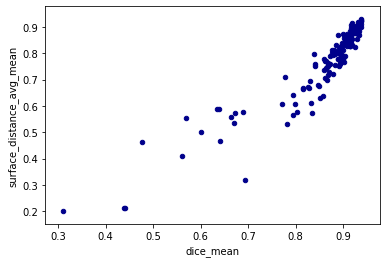

0.5914828733704434


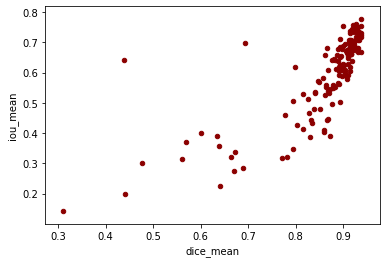

MC_dropout_quicknat
0.825344044346477


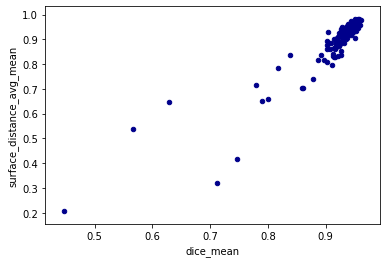

0.39538568171222543


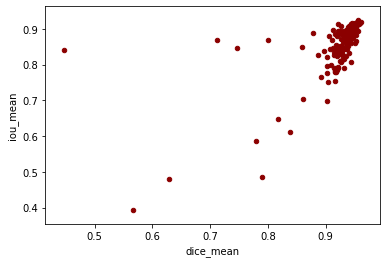

probabilistic_quicknat
0.8198119750548394


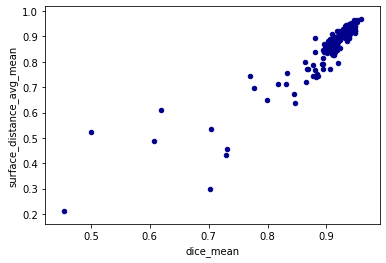

0.5092933723742227


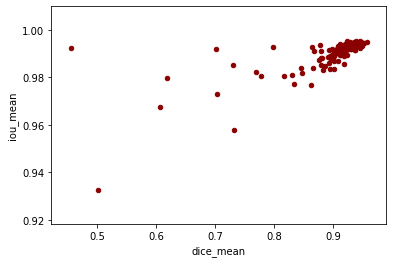

hierarchical_quicknat
0.8178009490409649


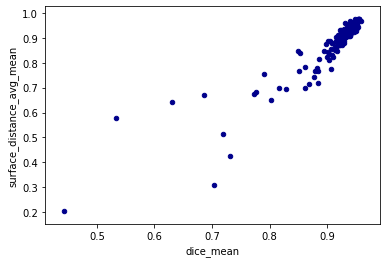

0.3453262196459317


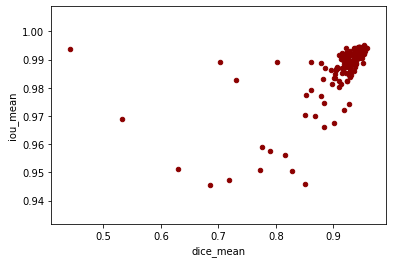

In [186]:
from sklearn.linear_model import LinearRegression
for key, value in model_merged_feats_path_combined.items():
    print(key)
    df = pd.read_csv(value)
    df = rename(df)
    df = transform_to_categorical(df, ['diabetes_status', 'sex'])
    df, normalised_cols = z_score_column_normalise(df, ['seg_spleen', 'seg_liver'])
    df = df.fillna(0)
    
 
    df.plot.scatter(x='dice_mean', y='surface_distance_avg_mean',c='DarkBlue')
    X, y = df['dice_mean'].values.reshape(-1,1),df['surface_distance_avg_mean'].values.reshape(-1,1)
    reg = LinearRegression().fit(X, y)
    print(reg.score(X, y))
    plt.show()
    df.plot.scatter(x='dice_mean', y='iou_mean',c='DarkRed')
    X, y = df['dice_mean'].values.reshape(-1,1),df['iou_mean'].values.reshape(-1,1)
    reg = LinearRegression().fit(X, y)
    print(reg.score(X, y))
    plt.show()